In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

### Count data

From Wikipedia:

> The Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time if these events occur with a known constant mean rate and independently of the time since the last event.

#### Rate parameter $\lambda$

Expected number of events in the fixed time interval

#### Probability mass function
$$
x\sim \operatorname{Poisson}(\lambda)\qquad\Longleftrightarrow\qquad \mathbb{P}[x=k] = e^{-\lambda}\frac{\lambda^k}{k!},\quad k=0,1,\ldots
$$

#### Expectation and variance
If $x\sim \operatorname{Poisson}(\lambda)$, then
$$
\mathbb{E}[x] = \lambda\qquad\text{and}\qquad\mathbb{V}[x]=\lambda.
$$

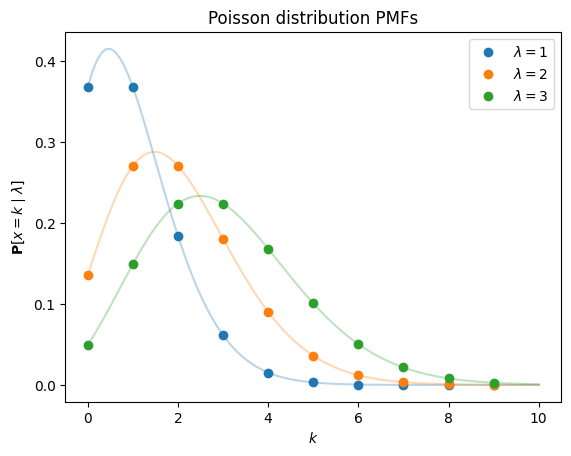

In [2]:
import scipy.stats as stats
import scipy.special as special

ks = np.arange(10)
ts = np.linspace(0, 10, 100)
for i in range(3):
    plt.plot(ks, stats.poisson(i + 1).pmf(ks), "o", label=f"$\\lambda={i + 1}$")
    plt.plot(
        ts, np.exp(-(i + 1)) * (i + 1) ** ts / special.gamma(ts + 1), f"C{i}", alpha=0.3
    )
plt.legend()
plt.title("Poisson distribution PMFs")
plt.xlabel("$k$")
plt.ylabel("$\\mathbf{P}[x=k\\mid\\lambda]$")
plt.show()

### Mule kicks

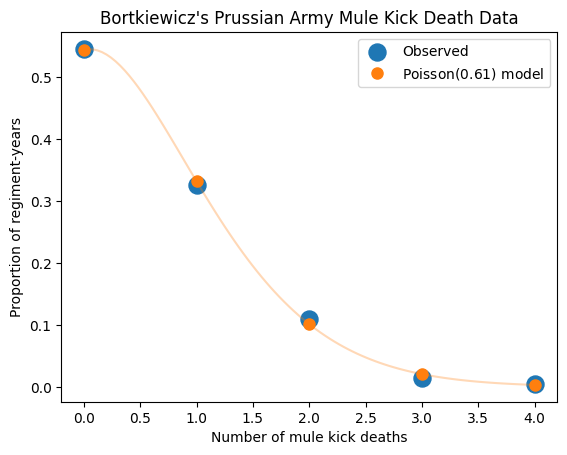

In [3]:
counts = np.arange(5)
count_occurences = np.array([109, 65, 22, 3, 1])
lam = np.sum(count_occurences * counts) / count_occurences.sum()
plt.scatter(counts, count_occurences / count_occurences.sum(), s=150, label="Observed")
plt.plot(
    counts,
    stats.poisson(lam).pmf(counts),
    "oC1",
    ms=8,
    label=f"$\\operatorname{{Poisson}}({lam:.2f})$ model",
)
ts = np.linspace(0, 4, 100)
plt.plot(ts, np.exp(-lam) * lam**ts / special.gamma(ts + 1), "C1", alpha=0.3)
plt.xlabel("Number of mule kick deaths")
plt.ylabel("Proportion of regiment-years")
plt.title("Bortkiewicz's Prussian Army Mule Kick Death Data")
plt.legend()
plt.show()

### Poisson Regression

- Counts $y$ might depend on predictors $x\in\mathbb{R}^p$ through the rate parameter $\lambda$.

- For example: The number of awards a student wins in a year might be associated with their program of study and on a standardized test score.

In [4]:
df = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")
df

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40
...,...,...,...,...
195,100,2,2,71
196,143,2,3,75
197,68,1,2,71
198,57,0,2,72


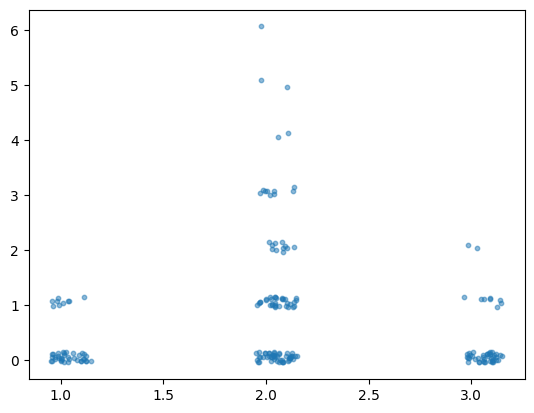

In [5]:
plt.scatter(
    df["prog"] + np.random.uniform(size=200) * 0.2 - 0.05,
    df["num_awards"] + np.random.uniform(size=200) * 0.2 - 0.05,
    s=10,
    alpha=0.5,
)

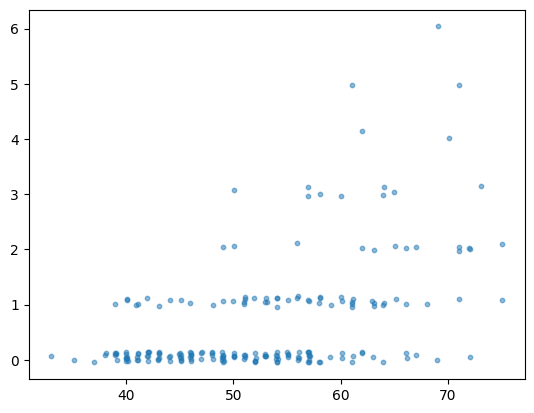

In [6]:
plt.scatter(
    df["math"] + np.random.uniform(size=200) * 0.2 - 0.05,
    df["num_awards"] + np.random.uniform(size=200) * 0.2 - 0.05,
    s=10,
    alpha=0.5,
)

### Log-linear modeling of count data

- Since $\lambda > 0$, it doesn't make sense to represent lambda as a linear function of predictors. Model $\lambda$ as the exponential of a linear function of the predictors: $\lambda=e^{\beta\cdot x\cdot}$.

- Model counts data by a Poisson distribution whose rate depends on the predictor vector $x$ as above:
  $$
  y\sim\operatorname{Poisson}(e^{\beta\cdot x})
  $$

In [8]:
y = df["num_awards"]
X = df[["math"]].copy()
X["prog_2"] = df["prog"] == 2
X["prog_3"] = df["prog"] == 3
X["Intercept"] = 1
X = X.astype(float)

fit = sm.Poisson(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.913761
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                        Poisson   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Mon, 17 Mar 2025   Pseudo R-squ.:                  0.2118
Time:                        12:49:12   Log-Likelihood:                -182.75
converged:                       True   LL-Null:                       -231.86
Covariance Type:            nonrobust   LLR p-value:                 3.747e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
math           0.0702      0.011      6.619      0.000       0.049       0.091
prog_2         1.0839      0.358      3.025      0.002       0.382       1.786
prog_3         0.3698      0.441      0.838      0.402      -0.495       1.234
Intercept     -5.2471      0.658     -7.969      0.000      -6.538      -3.957
==============================================================================
"""

In [9]:
min_math = df["math"].min()
max_math = df["math"].max()
math = np.linspace(min_math, max_math, 100)

X_test_prog_1 = pd.DataFrame(
    {
        "math": math,
        "prog_2": [0.0 for _ in math],
        "prog_3": [0.0 for _ in math],
        "Intercept": [1.0 for _ in math],
    }
)

X_test_prog_2 = pd.DataFrame(
    {
        "math": math,
        "prog_2": [1.0 for _ in math],
        "prog_3": [0.0 for _ in math],
        "Intercept": [1.0 for _ in math],
    }
)

X_test_prog_3 = pd.DataFrame(
    {
        "math": math,
        "prog_2": [0.0 for _ in math],
        "prog_3": [1.0 for _ in math],
        "Intercept": [1.0 for _ in math],
    }
)

lambda_prog_1 = fit.predict(X_test_prog_1)
lambda_prog_2 = fit.predict(X_test_prog_2)
lambda_prog_3 = fit.predict(X_test_prog_3)

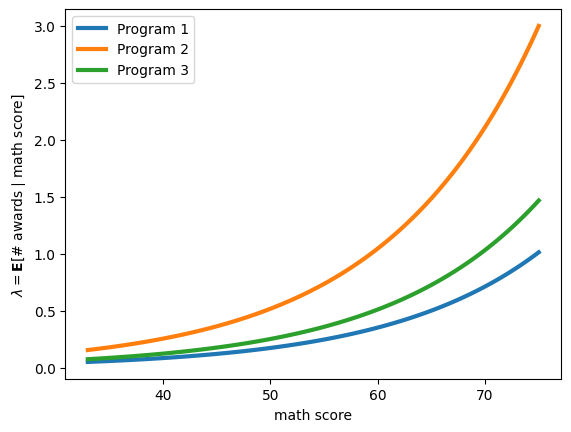

In [12]:
plt.plot(math, lambda_prog_1, lw=3, label="Program 1")
plt.plot(math, lambda_prog_2, lw=3, label="Program 2")
plt.plot(math, lambda_prog_3, lw=3, label="Program 3")
plt.xlabel("math score")
plt.ylabel("$\\lambda=\\mathbf{E}[\\text{\\# awards}\\mid \\text{math score}]$")
plt.legend()
plt.show()

In [14]:
assert np.allclose(np.exp(X_test_prog_1 @ fit.params), fit.predict(X_test_prog_1))

### Overdispersion and the negative binomial distribution

- If $x\sim \operatorname{Poisson}(\lambda)$, then
$$
\mathbb{E}[x] = \lambda\qquad\text{and}\qquad\mathbb{V}[x]=\lambda.
$$

- A distribution with mean $\mu$ and variance $\sigma^2$ displays **overdispersion** if $\sigma^2 > \mu$.

### Insurance claim data

| # claims in last year | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 1 |
|----------------------:|--:|--:|--:|--:|--:|--:|--:|--:|
| **# of customers**        | **7840**|**1317**|**239**|**42**|**14**|**4**|**4**|**1** |

In [ ]:
counts = pd.Series(
    [7840, 1317, 239, 42, 14, 4, 4, 1], index=np.arange(8), name="counts"
)
counts

0    7840
1    1317
2     239
3      42
4      14
5       4
6       4
7       1
Name: counts, dtype: int64

In [ ]:
m = counts.dot(counts.index) / counts.sum()
v = counts.dot((counts.index - m) ** 2) / counts.sum()
print(f"m = {m:.2f}, v = {v:.2f}")

m = 0.21, v = 0.29


The negative binomial distribution $\operatorname{NB}(r,p)$ has two parameters $r>0$ and $p\in(0,1)$. It's mean and variance are:
$$
\mu=\frac{r(1-p)}{p},\qquad
\sigma^2 = \frac{r(1-p)}{p^2} = \frac{\mu}{p}
$$

We can invert these relationships:
$$
p = \frac{\mu}{\sigma^2},\quad
r = \frac{\mu^2}{\sigma^2 - \mu}
$$
(Note that $p\in(0,1)$ and $r > 0$ if and only if $\sigma^2 > \mu > 0$.)

Using these formulas, we can estimate $p$ and $r$ by plugging in standard estimators for $\mu$ and $\sigma^2$.

Finally, note the identity
$$
\sigma^2 = \mu + \frac{\mu^2}{r}.
$$
Thus, values of $r$ close to $0$ indicate a lot of overdispersion while large values of $r$ mean little overdispersion.

In [28]:
p = m / v
r = m**2 / (v - m)
print(f"p = {p:.2f}, r = {r:.2f}")

assert np.isclose(m, r * (1 - p) / p)
assert np.isclose(v, r * (1 - p) / p**2)

p = 0.74, r = 0.62


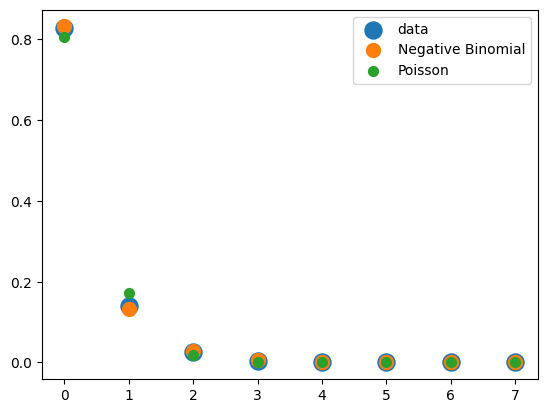

In [ ]:
plt.scatter(counts.index, counts / counts.sum(), s=150, label="data")
plt.scatter(
    counts.index, stats.nbinom(r, p).pmf(counts.index), s=100, label="Negative Binomial"
)
plt.scatter(counts.index, stats.poisson(m).pmf(counts.index), s=50, label="Poisson")
plt.legend()
plt.show()

In [82]:
y = []
for i, x in counts.items():
    y.extend([i for _ in range(x)])

y = np.array(y)
assert all(y[:7840] == 0)
assert all(y[7840 : 7840 + 1317] == 1)
# etc.
assert y[-1] == 7
X = pd.DataFrame({"Intercept": [1.0 for _ in y]})
fit = sm.NegativeBinomial(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.565272
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                 9461
Model:               NegativeBinomial   Df Residuals:                     9460
Method:                           MLE   Df Model:                            0
Date:                Mon, 17 Mar 2025   Pseudo R-squ.:              -5.200e-09
Time:                        14:29:57   Log-Likelihood:                -5348.0
converged:                       True   LL-Null:                       -5348.0
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5401      0.025    -60.696      0.000      -1.590      -1.490
alpha          1.4264      0.128     11.173      0.000       1.176       1.677
==============================================================================
"""

In [ ]:
mu = np.exp(fit.params["Intercept"])
r = 1 / fit.params["alpha"]
p = r / (r + mu)
var = mu / p
print(f"p = {p:.2f}, r = {r:.2f}")  # MLEs, not MMEs!
print(f"mu = {mu:.2f}, var = {var:.2f}")

p = 0.77, r = 0.70
mu = 0.21, var = 0.28


The $\alpha$ parameter is the inverse of the "reciprocal dispersion" parameter $r$. Thus, $\alpha$ controls the amount of overdispersion:
$$
\sigma^2 = \mu + \alpha\mu^2
$$

In [83]:
data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")

In [69]:
data

,id,gender,math,daysabs,prog
0,1001.0,male,63.0,4.0,2.0
1,1002.0,male,27.0,4.0,2.0
2,1003.0,female,20.0,2.0,2.0
3,1004.0,female,16.0,3.0,2.0
4,1005.0,female,2.0,3.0,2.0
...,...,...,...,...,...
309,2153.0,male,26.0,1.0,2.0
310,2154.0,female,79.0,3.0,3.0
311,2155.0,female,59.0,0.0,2.0
312,2156.0,female,90.0,0.0,3.0


In [84]:
data["prog"] = data["prog"].map({1: "General", 2: "Academic", 3: "Vocational"})
data.head()

,id,gender,math,daysabs,prog
0,1001.0,male,63.0,4.0,Academic
1,1002.0,male,27.0,4.0,Academic
2,1003.0,female,20.0,2.0,Academic
3,1004.0,female,16.0,3.0,Academic
4,1005.0,female,2.0,3.0,Academic


In [85]:
data["prog"].value_counts()

prog
Academic      167
Vocational    107
General        40
Name: count, dtype: int64

In [ ]:
X = pd.DataFrame(
    {
        "math": data["math"] / 100,
        "academic": data["prog"] == "Academic",
        "general": data["prog"] == "General",
        "vocational": data["prog"] == "Vocational",
    }
).astype(float)
y = data["daysabs"]

In [106]:
fit = sm.NegativeBinomial(y, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 2.756780
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                daysabs   No. Observations:                  314
Model:               NegativeBinomial   Df Residuals:                      310
Method:                           MLE   Df Model:                            3
Date:                Mon, 17 Mar 2025   Pseudo R-squ.:                 0.03441
Time:                        14:48:51   Log-Likelihood:                -865.63
converged:                       True   LL-Null:                       -896.47
Covariance Type:            nonrobust   LLR p-value:                 2.563e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
math          -0.5993      0.251     -2.390      0.017      -1.091      -0.108
academic       2.1745      0.132     16.525      0.000       1.917       2.432
general        2.6153      0.196     13.319      0.000       2.230       3.000
vocational     1.3366      0.187      7.160      0.000       0.971       1.703
alpha          0.9683      0.100      9.729      0.000       0.773       1.163
==============================================================================
"""

In [ ]:
X_test_voc = pd.DataFrame(
    {
        "math": np.linspace(0, 1, 100),
        "academic": [0 for _ in range(100)],
        "general": [0 for _ in range(100)],
        "vocational": [1 for _ in range(100)],
    }
).astype(float)
X_test_acad = pd.DataFrame(
    {
        "math": np.linspace(0, 1, 100),
        "academic": [1 for _ in range(100)],
        "general": [0 for _ in range(100)],
        "vocational": [0 for _ in range(100)],
    }
).astype(float)
X_test_gen = pd.DataFrame(
    {
        "math": np.linspace(0, 1, 100),
        "academic": [0 for _ in range(100)],
        "general": [1 for _ in range(100)],
        "vocational": [0 for _ in range(100)],
    }
).astype(float)
y_test_voc = fit.predict(X_test_voc)
y_test_acad = fit.predict(X_test_acad)
y_test_gen = fit.predict(X_test_gen)

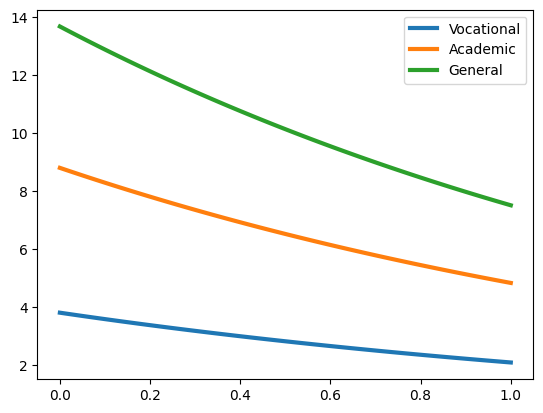

In [108]:
plt.plot(X_test_voc["math"], y_test_voc, lw=3, label="Vocational")
plt.plot(X_test_acad["math"], y_test_acad, lw=3, label="Academic")
plt.plot(X_test_gen["math"], y_test_gen, lw=3, label="General")
plt.legend()
plt.show()

#### Exposure

- In most applications of count-data regression, there is a baseline or *exposure*.

- Negative binomial model with *rate* $\theta_i$, *exposure* $u_i$, and *reciprocal dispersion* $r$:
  $$
  \operatorname{NB}(\mu=u_i\theta_i, r)
  $$

In [4]:
df = pd.read_csv("../data/roaches.csv").drop(columns=["Unnamed: 0"])
df

,y,roach1,treatment,senior,exposure2
0,153,308.00,1,0,0.800000
1,127,331.25,1,0,0.600000
2,7,1.67,1,0,1.000000
3,7,3.00,1,0,1.000000
4,0,2.00,1,0,1.142857
...,...,...,...,...,...
257,0,0.00,0,1,1.485714
258,0,0.00,0,1,1.000000
259,0,0.00,0,1,1.000000
260,171,0.00,0,1,1.000000


#### Example

> For a more complicated example, we consider a study of the effect of integrated pest management on
reducing cockroach levels in urban apartments. In this experiment, the treatment and control were
applied to 158 and 104 apartments, respectively, and the outcome measurement $y_i$ in each apartment
$i$ was the number of roaches caught in a set of traps. Different apartments had traps for different
numbers of days, and we label as $u_i$ the number of trap-days. The natural model for the roach counts
is then $y_i\sim\operatorname{NB}(u_i e^{\beta\cdot x_i},r)$, where $x$ represents the regression predictors (in this case, a pre-treatment roach level, a treatment indicator, and an indicator for whether the apartment is in a "senior" building restricted to the elderly, and the constant term). &mdash; GHV p. 268

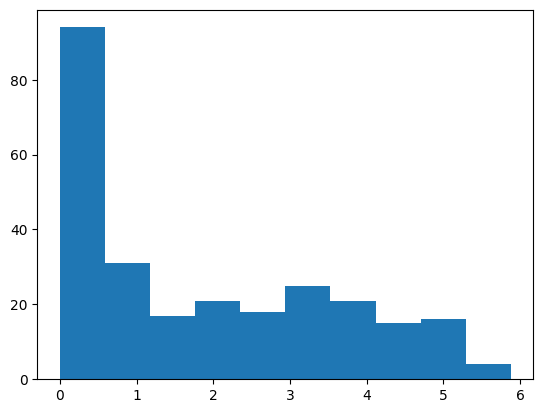

In [71]:
_, bins, *__ = plt.hist(np.log(df["y"] + 1))

In [66]:
# roaches$roach100 <- roaches$roach1/100
# fit_1 <- stan_glm(y ~ roach100 + treatment + senior

y = df["y"]
X = df[["treatment", "senior"]].copy()
X["roach100"] = df["roach1"] / 100
X["Intercept"] = 1
X

,treatment,senior,roach100,Intercept
0,1,0,3.0800,1
1,1,0,3.3125,1
2,1,0,0.0167,1
3,1,0,0.0300,1
4,1,0,0.0200,1
...,...,...,...,...
257,0,1,0.0000,1
258,0,1,0.0000,1
259,0,1,0.0000,1
260,0,1,0.0000,1


In [67]:
sm.NegativeBinomial?

Init signature:
sm.NegativeBinomial(
    endog,
    exog,
    loglike_method='nb2',
    offset=None,
    exposure=None,
    missing='none',
    check_rank=True,
    **kwargs,
)
Docstring:     
Negative Binomial Model

Parameters
----------
endog : array_like
    A 1-d endogenous response variable. The dependent variable.
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user. See
    :func:`statsmodels.tools.add_constant`.
loglike_method : str
    Log-likelihood type. 'nb2','nb1', or 'geometric'.
    Fitted value :math:`\mu`
    Heterogeneity parameter :math:`\alpha`

    - nb2: Variance equal to :math:`\mu + \alpha\mu^2` (most common)
    - nb1: Variance equal to :math:`\mu + \alpha\mu`
    - geometric: Variance equal to :math:`\mu + \mu^2`
offset : array_like
    Offset is added to the linear prediction with coefficient equal to 1.
exposure :

In [103]:
# fit = sm.NegativeBinomial(y, X, exposure=df["exposure2"]).fit()
fit = sm.NegativeBinomial(y, X, offset=np.log(df["exposure2"])).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 3.399476
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  262
Model:               NegativeBinomial   Df Residuals:                      258
Method:                           MLE   Df Model:                            3
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:               1.392e-05
Time:                        14:40:19   Log-Likelihood:                -890.66
converged:                       True   LL-Null:                       -890.68
Covariance Type:            nonrobust   LLR p-value:                    0.9990
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0344      0.247      0.140      0.889      -0.449       0.518
senior        -0.0067      0.263     -0.025      0.980      -0.522       0.509
roach100      -0.0217      0.251     -0.086      0.931      -0.514       0.471
Intercept     -0.0026      0.231     -0.011      0.991      -0.456       0.451
alpha          3.6889      0.352     10.492      0.000       3.000       4.378
==============================================================================
"""

In [95]:
r = 1 / fit.params["alpha"]
r

0.27108717314427644

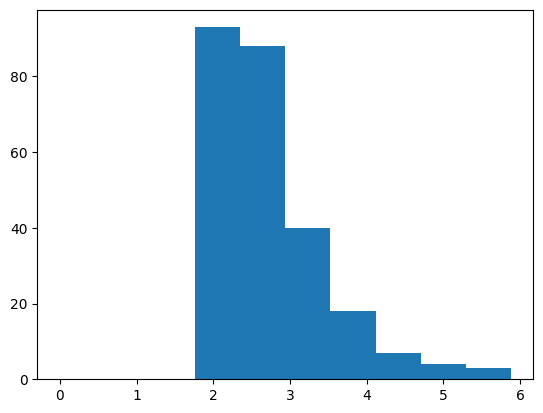

In [97]:
mu = df["exposure2"] * fit.predict(X)
plt.hist(np.log(mu + 1), bins=bins)

In [90]:
assert np.allclose(fit.predict(X), np.exp(X @ fit.params[X.columns]))

In [118]:
import bambi as bmb

# bambi poisson model
roaches = df.copy()
roaches["roach100"] = roaches["roach1"] / 100
model = bmb.Model(
    "y ~ roach100 + treatment  + senior + offset(log(exposure2))",
    family="negativebinomial",
    data=roaches,
)
fit = model.fit(draws=10000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, roach100, treatment, senior]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


In [119]:
import arviz as az

In [120]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.269,0.026,0.221,0.318,0.000,0.000,53076.0,32969.0,1.0
Intercept,0.010,0.236,-0.436,0.449,0.001,0.001,59814.0,34363.0,1.0
roach100,0.017,0.258,-0.467,0.497,0.001,0.001,44714.0,30921.0,1.0
treatment,0.025,0.250,-0.435,0.503,0.001,0.001,60065.0,34396.0,1.0
senior,0.009,0.268,-0.495,0.507,0.001,0.001,56963.0,33171.0,1.0


In [115]:
# bambi poisson model
model_2 = bmb.Model(
    "y ~ roach1 + treatment  + senior + offset(log(exposure2))",
    family="negativebinomial",
    data=roaches,
)
idata_2 = model_2.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, roach1, treatment, senior]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [116]:
az.summary(idata_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.269,0.026,0.221,0.318,0.000,0.000,5937.0,3397.0,1.0
Intercept,0.009,0.231,-0.419,0.434,0.003,0.003,5143.0,3455.0,1.0
roach1,0.000,0.003,-0.004,0.005,0.000,0.000,5120.0,3019.0,1.0
treatment,0.026,0.253,-0.469,0.471,0.004,0.004,5180.0,3143.0,1.0
senior,0.008,0.264,-0.510,0.488,0.004,0.004,5366.0,3275.0,1.0


In [117]:
model

       Formula: y ~ roach100 + treatment  + senior + offset(log(exposure2))
        Family: negativebinomial
          Link: mu = log
  Observations: 262
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.5238)
            roach100 ~ Normal(mu: 0.0, sigma: 3.3281)
            treatment ~ Normal(mu: 0.0, sigma: 5.1097)
            senior ~ Normal(mu: 0.0, sigma: 5.4283)
        
        Offset effects
            offset(log(exposure2)) ~ 1
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()